In [68]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.Functions.functions import *
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.patches as mpatches

choose a player from all the league
Feel free to choose your own favorite player!

In [111]:
player = "L. James"

Here, we analyse in each match the actions of the player

In [112]:
with open('Data/NBA_Matches_Stats.json') as f:
    data = json.load(f)

points = []
df = pd.DataFrame()
for d in data:
    for action in d["playByPlay"]["actions"]:
        if "Shot" in action['actionType']:
            if action["playerNameI"] == player:
                df = pd.concat([df, pd.DataFrame(action, index=[0])], ignore_index=True)

df = df.rename(columns={"actionType": "Shot Type"})


With that information, we can show all the shot he has tried and made

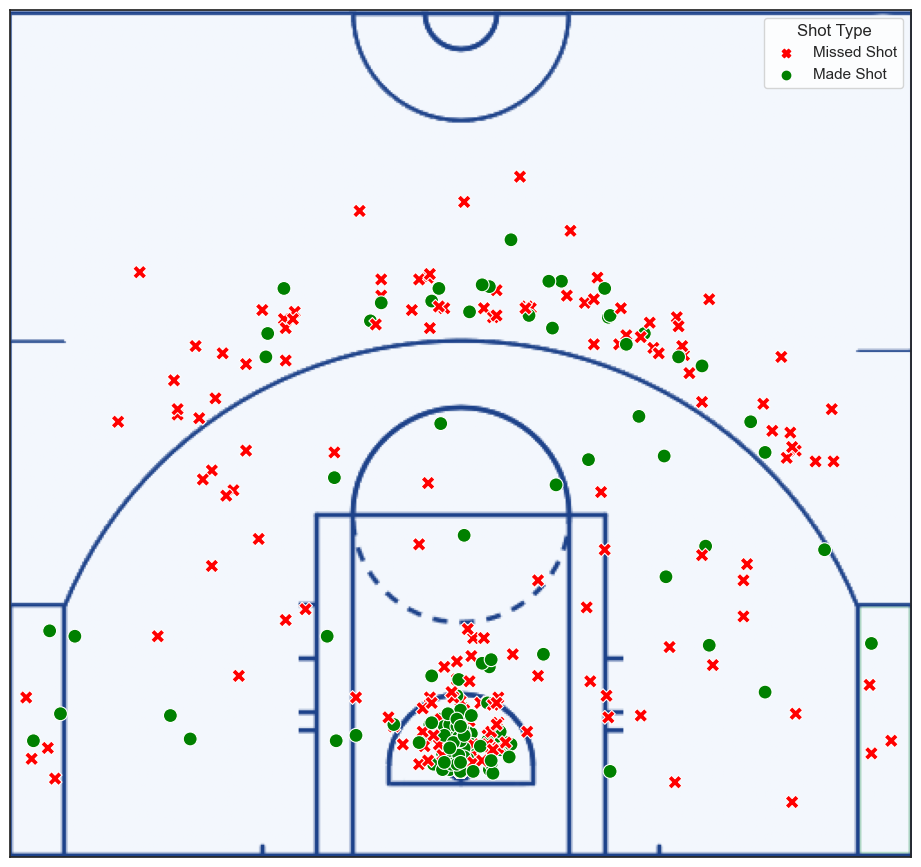

In [113]:
# change palette

img = plt.imread("Images/court.png")
fig, ax = plt.subplots(figsize=(12, 11))
ax.imshow(img, extent=[-270, 270, -67.5, 442.5])
# plot the shots
sns.set_theme(style="white", palette="muted", color_codes=True)
sns.scatterplot(x="xLegacy", y="yLegacy", data=df, hue="Shot Type", style="Shot Type", s=100, legend=True,
                palette=["red", "green"], style_order=["Made Shot", "Missed Shot"])
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(250, -250)
plt.ylim(-47.5, 422.5)

plt.show()

We can also see compared to the average shoot success of the league.
For this, we plot the different zones of where you can shoot, and make it green when its better, and red when its worse than the league average

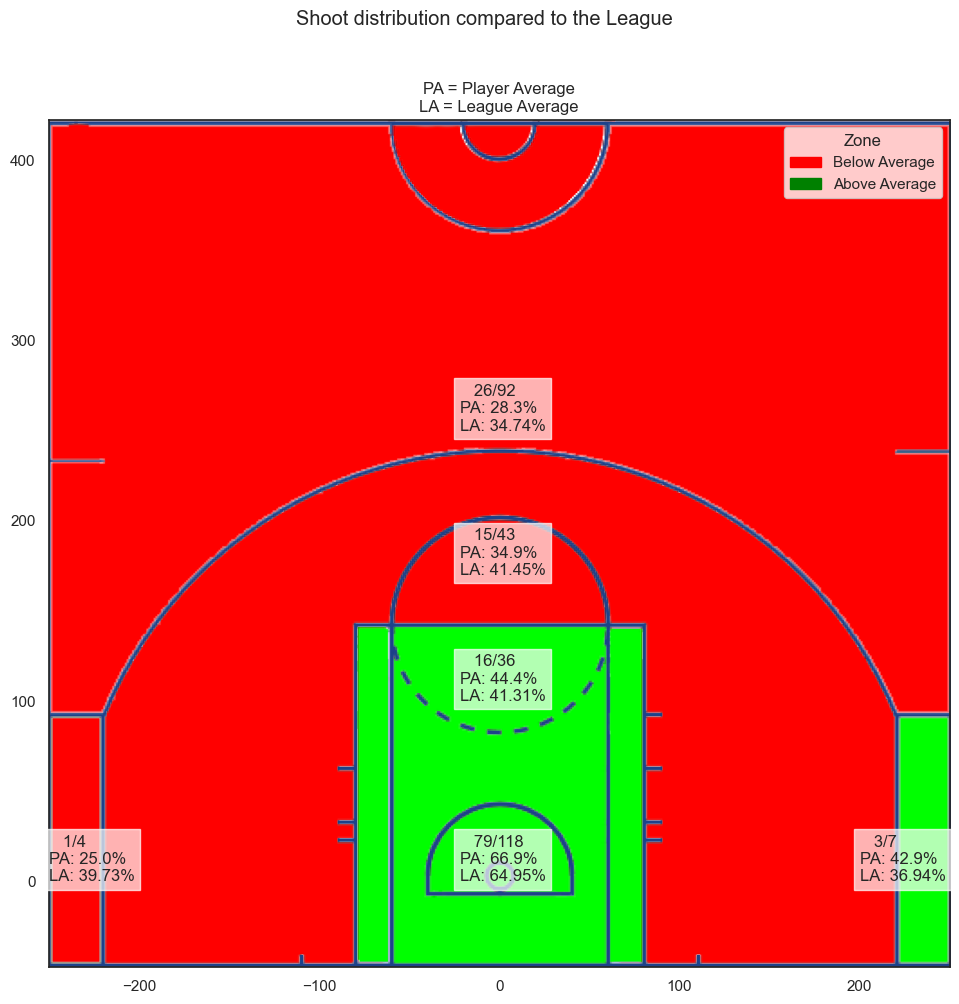

In [114]:

# add if the shot is a 3 pointer or not
df["zone"] = df.apply(lambda r: get_zone_(r), axis=1)

images = [(plt.imread("Images/court-top.png")), plt.imread("Images/court-inside.png"),
          plt.imread("Images/court-bottom-left.png"),
          plt.imread("Images/court-2points.png"),
          plt.imread("Images/court-hoop.png"), plt.imread("Images/court-bottom-right.png")]

# check the accuracy of each zones
zones = df.groupby(["zone", "Shot Type"]).agg({"Shot Type": "count"})
percent = zones["Shot Type"].unstack()["Made Shot"] / (
        zones["Shot Type"].unstack()["Missed Shot"] + zones["Shot Type"].unstack()["Made Shot"])

with open('Data/LeagueAverage.json') as f:
    league_avg = json.load(f)

league_avg = clean_league_avg(league_avg)


fig, ax = plt.subplots(figsize=(12, 11))
img = plt.imread("Images/court.png")
ax.imshow(img, extent=[-270, 270, -67.5, 442.5])

for id in range(len(images)):
    for i in images[id]:
        for j in i:
            if j[3] != 0:
                if (float(percent[id])) > float(league_avg[id]):
                    j[0] = j[2] = 0
                else:
                    j[2] = j[1] = 0

    ax.imshow(images[id], extent=[-270, 270, -67.5, 442.5])

add_text(ax,zones,league_avg,percent)
plt.xlim(-250, 250)
plt.ylim(-47.5, 422.5)

red_patch = mpatches.Patch(color='red', label='Below Average')
green_patch = mpatches.Patch(color='green', label='Above Average')
plt.legend(title="Zone",handles=[red_patch,green_patch])
plt.suptitle("Shoot distribution compared to the League")
plt.title("PA = Player Average\nLA = League Average")
plt.show()

Now we are going to analyse if the myth of being tall is really impactful of the number of points scored
For this, we are going to plot the points per min by the height

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '175.0'),
  Text(1, 0, '180.0'),
  Text(2, 0, '185.0'),
  Text(3, 0, '190.0'),
  Text(4, 0, '195.0'),
  Text(5, 0, '200.0'),
  Text(6, 0, '205.0'),
  Text(7, 0, '210.0'),
  Text(8, 0, '215.0'),
  Text(9, 0, '220.0')])

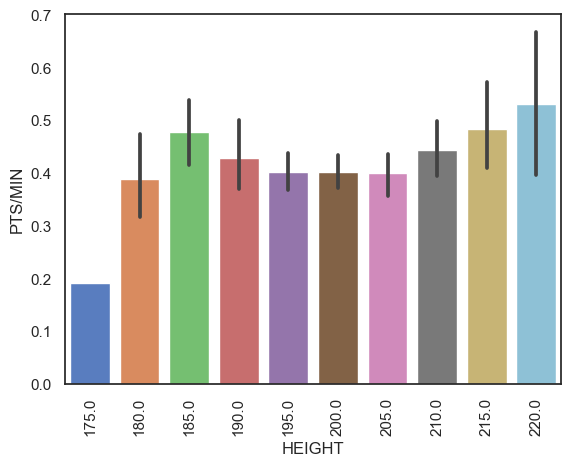

In [73]:
players = pd.read_csv("Data/NBA_Players_Stats.csv")
players = players[players["MIN"]!=0]
players["PTS/MIN"] = players["PTS"]/players["MIN"]
players["HEIGHT"] = players["PLAYER_HEIGHT_INCHES"]*2.54
players["HEIGHT"] = players["HEIGHT"] - players["HEIGHT"] % 5

sns.barplot(players,x="HEIGHT",y="PTS/MIN")
plt.xticks(rotation=90)


We can see that even though people are on average 2. meter tall, we can observe that people mesuring on average 1.85m can score the same as people above 2.10m
But may be its correlated to the position?

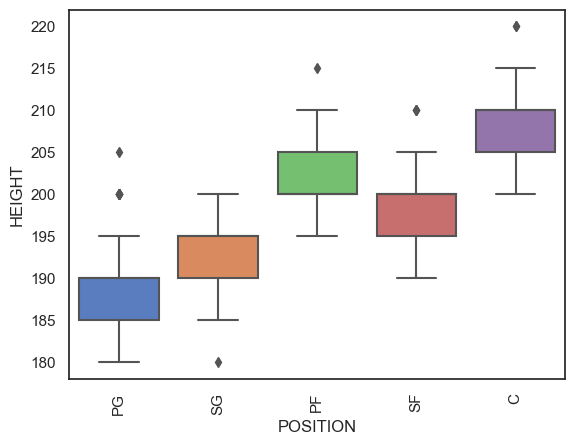

<AxesSubplot: xlabel='POSITION', ylabel='PTS/MIN'>

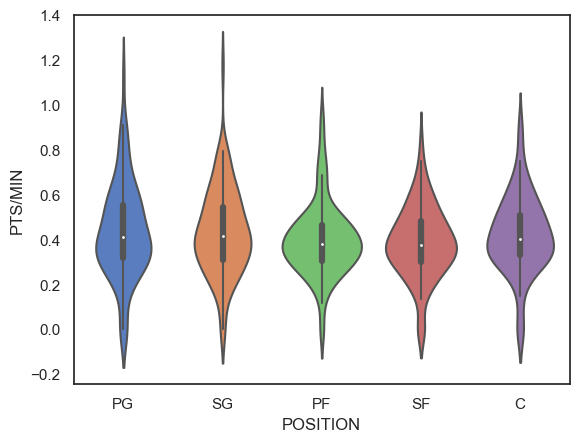

In [74]:
sns.boxplot(players,x="POSITION",y="HEIGHT")
plt.xticks(rotation=90)
plt.show()
#remove the outlier
players = players[players["PTS/MIN"]<2]
sns.violinplot(players,x="POSITION",y="PTS/MIN")


We observe that the height is correlated to the position,but, on the other hand the points/ minutes average is almost the same for every position
In consequences, we can deduce that the height is not really as important as everyone says (if you are taller than 1.80m

<AxesSubplot: >

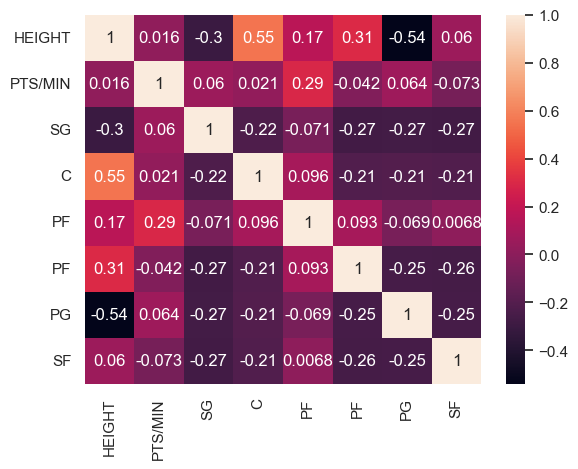

In [75]:
players2 = pd.concat([players,pd.get_dummies(players["POSITION"])],axis=1)
players2.head()
sns.heatmap(players2[["HEIGHT","PTS/MIN","SG","C","PF","PG","SF"]].corr(),annot=True)

This is confirmed by the correlation matrix

Now we load the dataset with only the player with more than 96 minutes played.

In [76]:
df_players = pd.read_csv("Data/NBA_Players_Stats.csv")
df = df_players.sample(frac=1)
df = df[df.MIN > 96]

As we can see, here the number of players and features for both dataset :

In [77]:
print("Number of players and features in the dataset :")
print(df_players.shape)
print("Number of players and features where the minute played (MIN) is superior to 96 minutes :")
print(df.shape)

Number of players and features in the dataset :
(474, 71)
Number of players and features where the minute played (MIN) is superior to 96 minutes :
(361, 71)


Let's take a look at the correlation between Field Goals Made, Field Goals Attempted, Rebound, Assists according to the team :

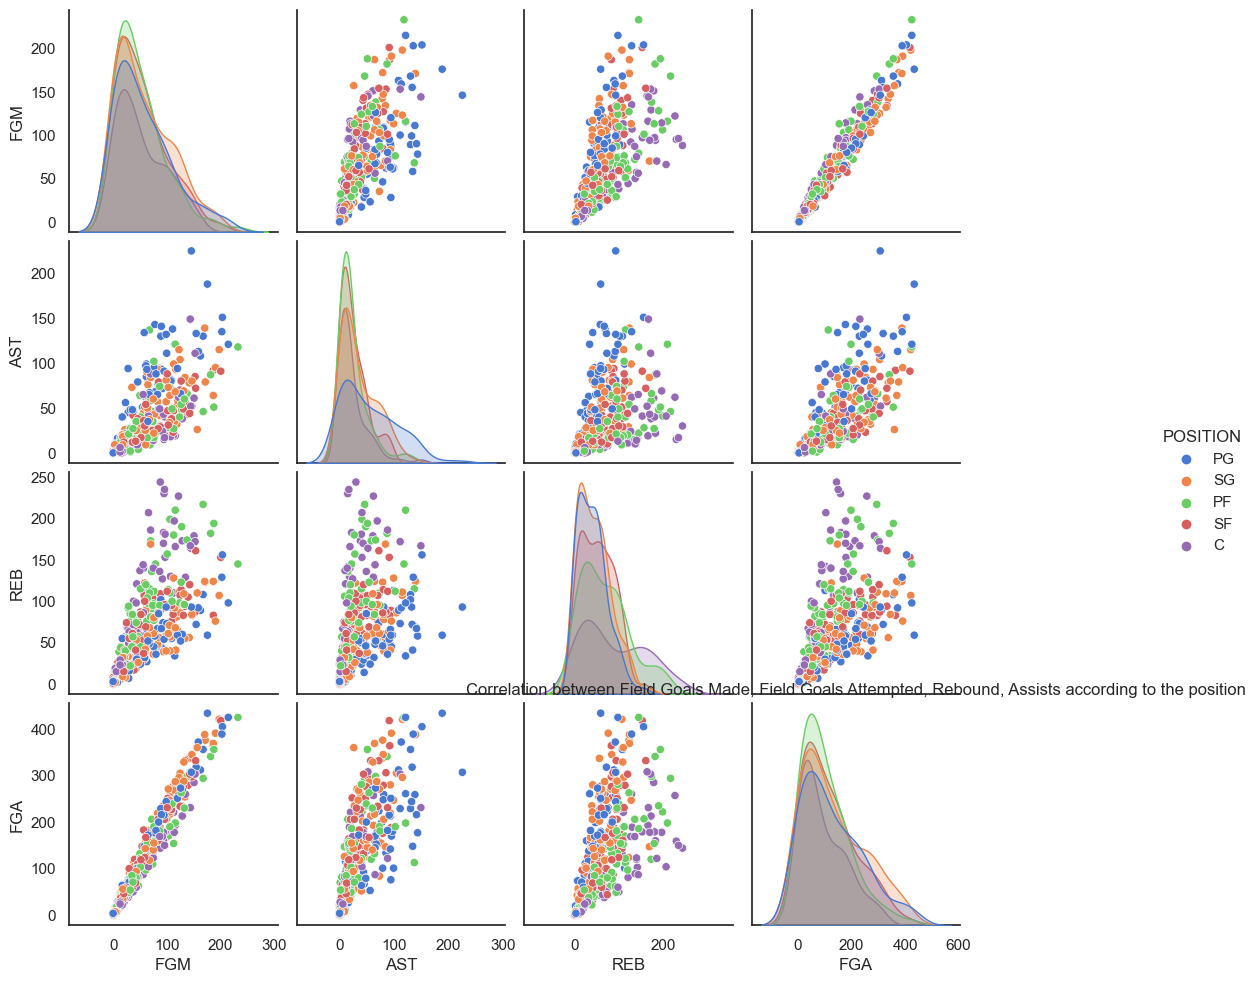

In [78]:
sns.pairplot(df_players[["FGM", "AST", "REB", "FGA", "POSITION"]], hue='POSITION')
plt.suptitle("Correlation between Field Goals Made, Field Goals Attempted, Rebound, Assists according to the position", y=1.04)
plt.show()

And the correlation between Minute Played, Loss, Win, Points and Game Played according to the team : 

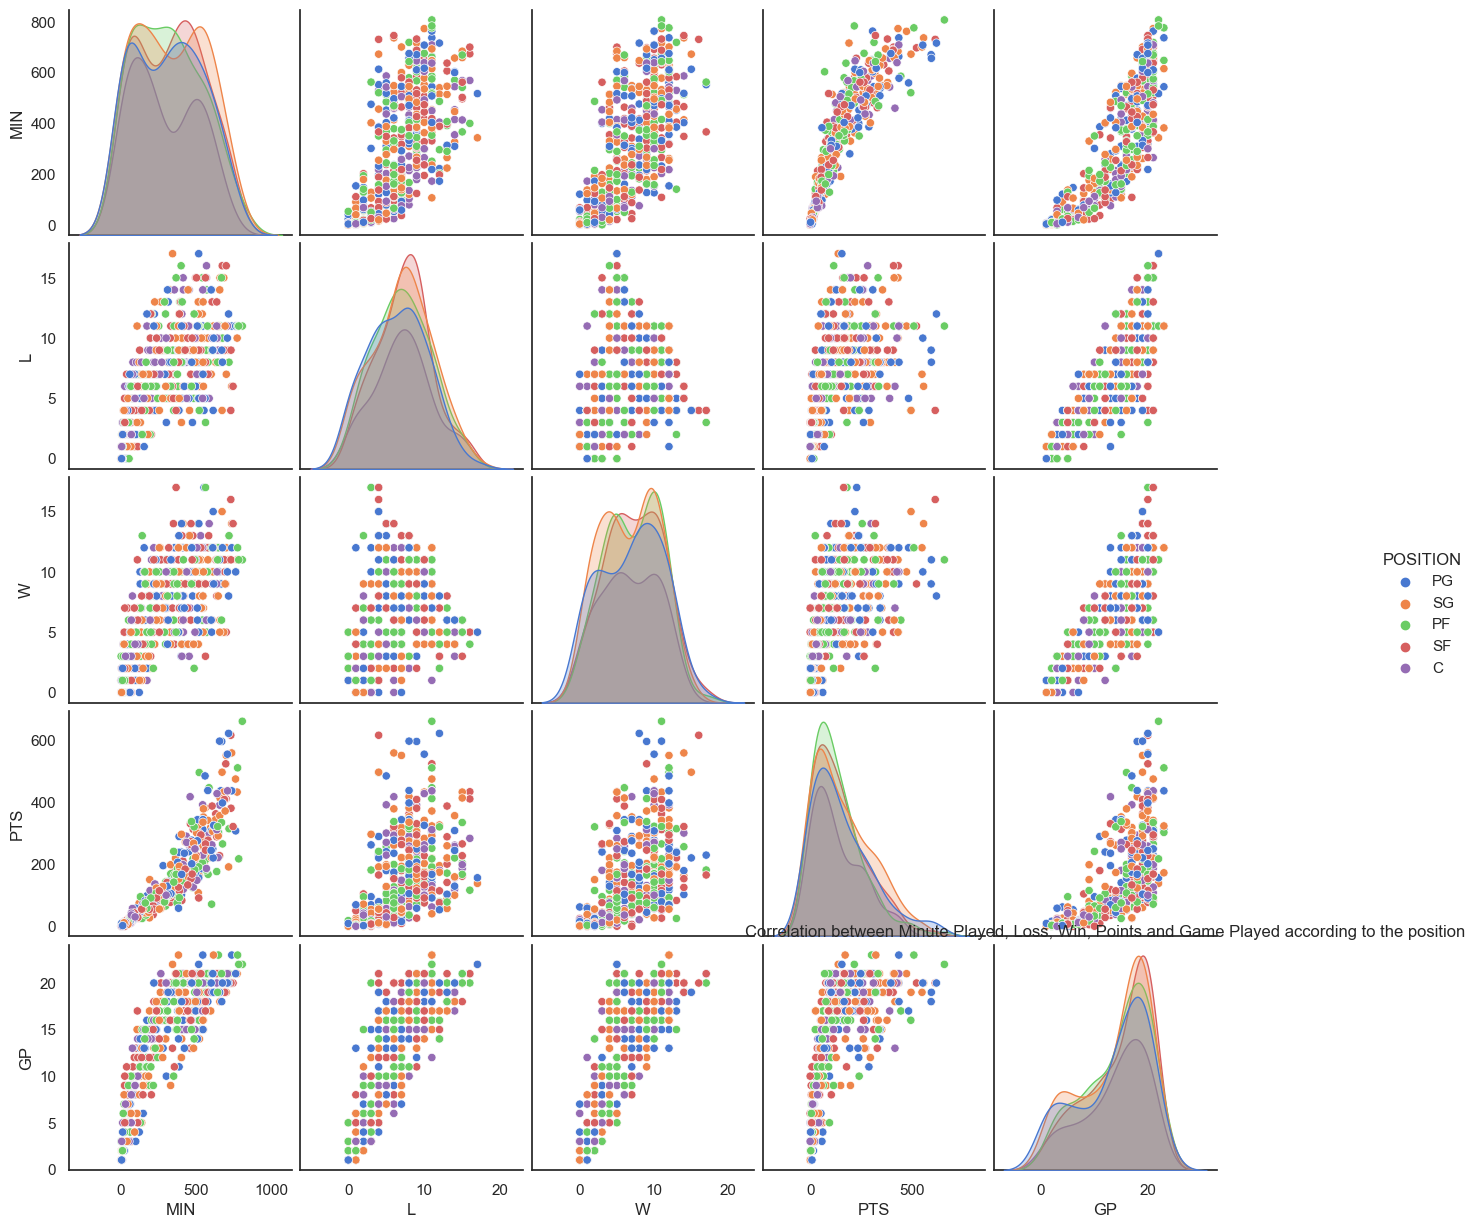

In [79]:
sns.pairplot(df_players[["MIN", "L", "W", "PTS", "GP", "POSITION"]], hue='POSITION')
plt.suptitle("Correlation between Minute Played, Loss, Win, Points and Game Played according to the position", y=1.04)
plt.show()

It is clearly seen that there is a correlation between the different features. 
Let us now look at their correlation coefficient to confirm our suppositions.

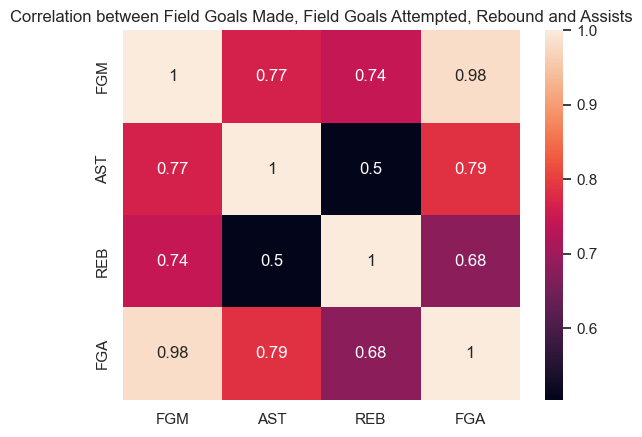

In [80]:
# Heat map of Field Goals Made, Field Goals Attempted, Rebound, Assists:
correlation = df_players[["FGM", "AST", "REB", "FGA"]].corr()
sns.heatmap(correlation, annot=True)
plt.title('Correlation between Field Goals Made, Field Goals Attempted, Rebound and Assists')
plt.show()

We can see that our variables are well correlated since the coefficients are greater than 0.5. 
They depend on each other.

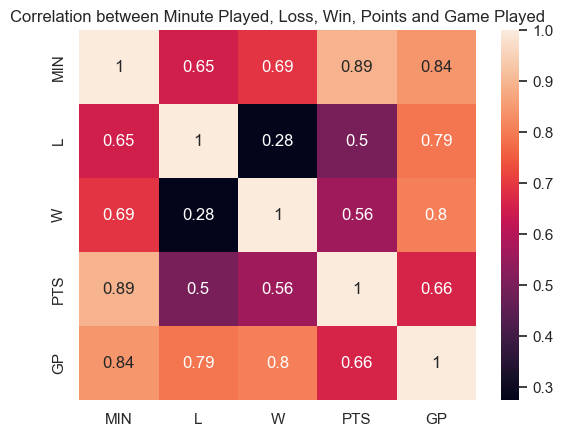

In [81]:
# Heat map of Minute Played, Loss, Win, Points and Game Played:
correlation2 = df_players[["MIN", "L", "W", "PTS", "GP"]].corr()
sns.heatmap(correlation2, annot=True)
plt.title('Correlation between Minute Played, Loss, Win, Points and Game Played')
plt.show()

As before, just Loss and Win as well as Points and Loss which are not correlated.

Let's now take a look at the correlation between Age, Rebounds, Assists, Steals, Blocks and Points but this time according to the position :

              AGE         REB         AST         STL         BLK         PTS
count  410.000000  410.000000  410.000000  410.000000  410.000000  410.000000
mean    25.802439   64.702439   37.458537   10.965854    7.351220  168.487805
std      4.687026   49.031194   36.228553    8.109206    7.877023  133.502273
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%     23.000000   26.000000   11.000000    5.000000    2.000000   62.000000
50%     25.000000   55.000000   22.000000    9.000000    5.000000  130.000000
75%     29.000000   91.750000   54.000000   16.000000    9.000000  249.000000
max     37.000000  244.000000  225.000000   47.000000   55.000000  660.000000


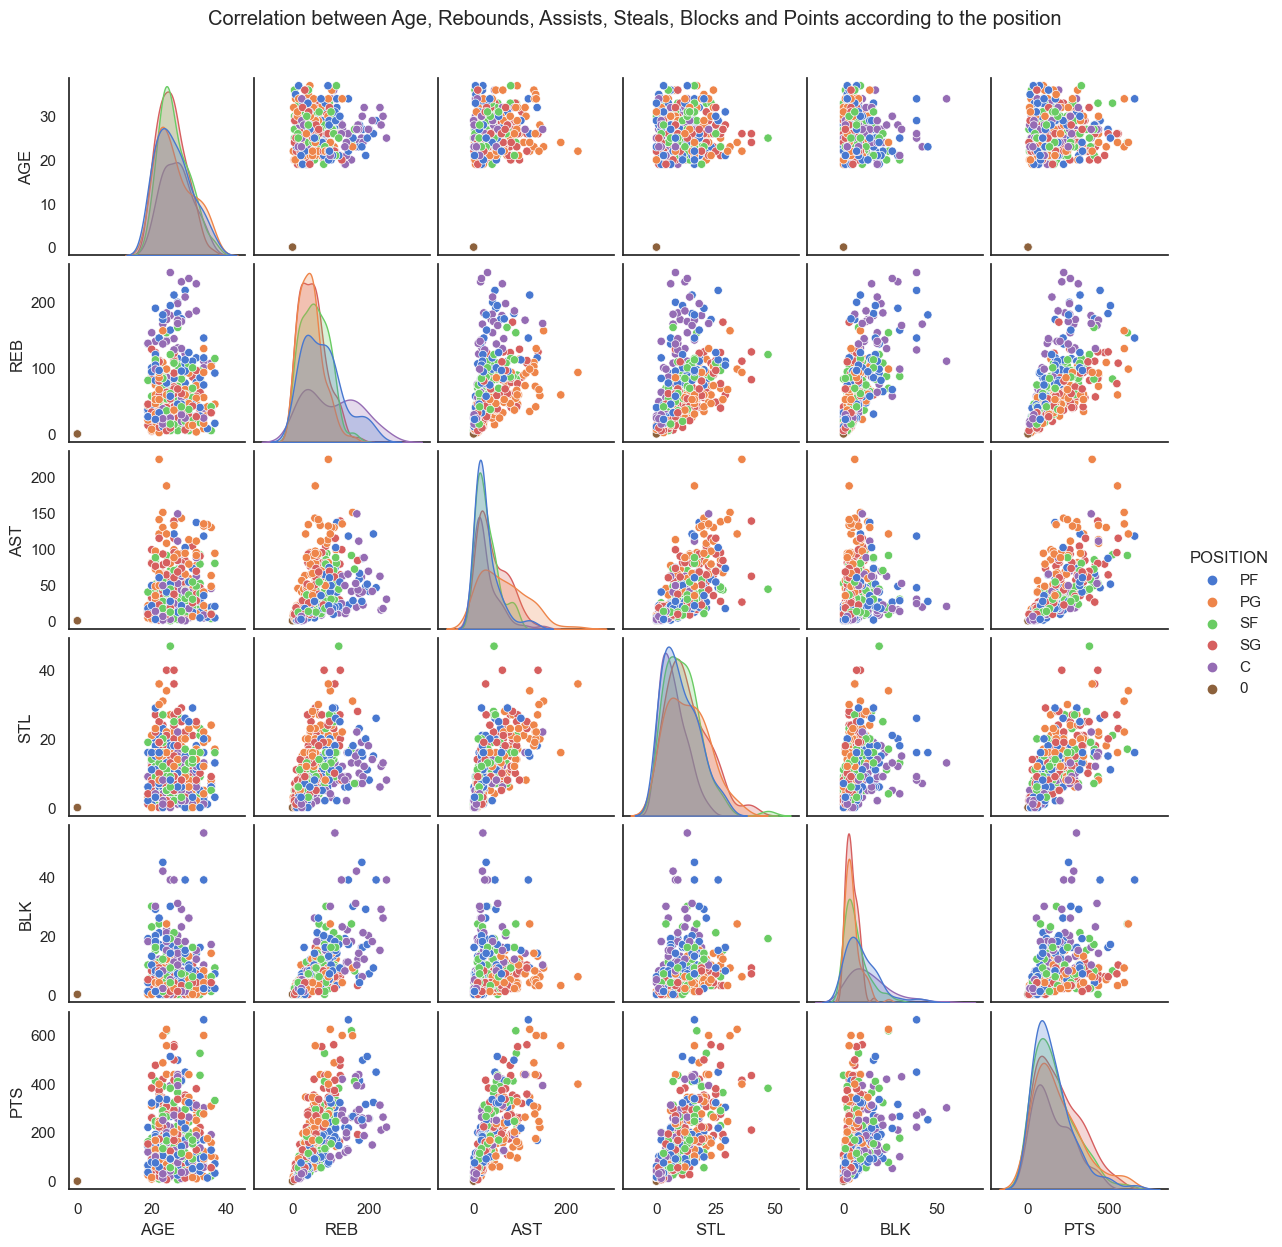

In [104]:
df_small = df[["POSITION", "AGE", "REB", "AST", "STL", "BLK", "PTS"]]
print(df_small.describe())
sns.pairplot(df_small, hue='POSITION', height=2)
plt.suptitle("Correlation between Age, Rebounds, Assists, Steals, Blocks and Points according to the position", y=1.04)
plt.show()

As we can see, the different features are correlated too. 
We are going to take a closer look at what we can do with this information. 
One graph that looked particularly interesting is the graph of  assists (AST) vs rebounds (REB). 
Let’s start here and normalize our AST and TRB variables to something that may control a bit more for variation in playing time. 

In [83]:
# calculating AST/MIN (assists per minute played) and REB/MIN (total rebounds per minute played)
df["REB/MIN"] = df["REB"]/df["MIN"]
df["AST/MIN"] = df["AST"]/df["MIN"]

Let's see if our clustering algorithm can correctly identify the clusters associated with each player position.

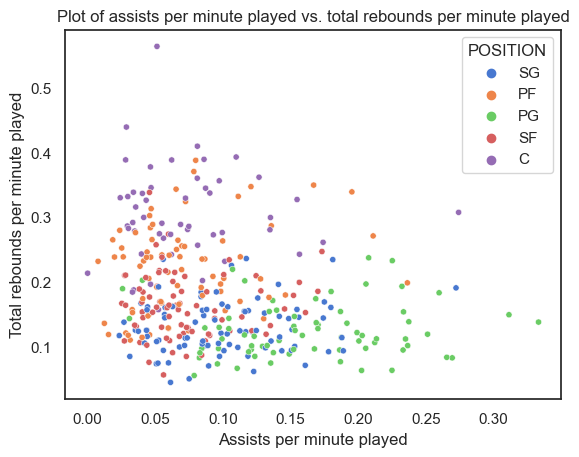

In [84]:
fig, ax = plt.subplots()
x_var = "AST/MIN"
y_var = "REB/MIN"
colors = {'SG': 'blue', 'PF': 'red', 'PG': 'green', 'C': 'purple', 'SF': 'orange'}
sns.scatterplot(df,x=x_var, y=y_var, hue="POSITION", s=20)
# set a title and labels
plt.title('Plot of assists per minute played vs. total rebounds per minute played')
plt.xlabel("Assists per minute played")
plt.ylabel("Total rebounds per minute played")
plt.show()

We can see some clusters here defined by our player position classes.
we can try to build a predictive model using unsupervised learning techniques such as K-means from the sklearn library.

In [85]:
# K means algorithm (unsupervised learning):
dfn = df[["AST/MIN", "REB/MIN"]]
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=500, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(dfn)

In [86]:
# Our 5 clusters
d0 = dfn[y_kmeans == 0]
d1 = dfn[y_kmeans == 1]
d2 = dfn[y_kmeans == 2]
d3 = dfn[y_kmeans == 3]
d4 = dfn[y_kmeans == 4]

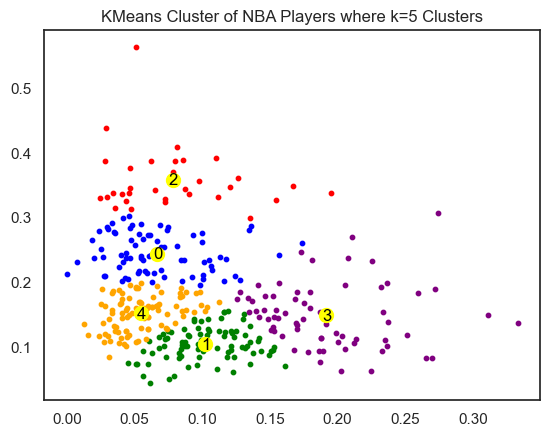

In [87]:
# Visualizing the clusters
plt.scatter(d0[x_var], d0[y_var], s=10, c='blue', label='D0')
plt.scatter(d1[x_var], d1[y_var], s=10, c='green', label='D1')
plt.scatter(d2[x_var], d2[y_var], s=10, c='red', label='D2')
plt.scatter(d3[x_var], d3[y_var], s=10, c='purple', label='D3')
plt.scatter(d4[x_var], d4[y_var], s=10, c='orange', label='D4')

# Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='yellow', label='Centroids')

for i in range(5):
     plt.text(kmeans.cluster_centers_[i, 0]-0.003, kmeans.cluster_centers_[i, 1]-0.008, i,fontdict={"color":"black"})
plt.title('KMeans Cluster of NBA Players where k=5 Clusters')
plt.show()

As we can see our algorithm identified clusters (with centroids in yellow) that are mapped with the actual player position clusters.
If we want, we can also search for a player and see in which cluster he is :

In [88]:
# Find player Aaron
Aaron = dfn.loc[df_players['PLAYER_NAME'] == 'Aaron Gordon',: ]

# Find player Duncan
Duncan = dfn.loc[df_players['PLAYER_NAME'] == 'Duncan Robinson',: ]

# print the players
print(Aaron)
print(Duncan)

    AST/MIN   REB/MIN
3  0.084555  0.235105
      AST/MIN   REB/MIN
128  0.074547  0.124245


In [89]:
# Change the dataframes to a list
Aaron_list = Aaron.values.tolist()
Duncan_list = Duncan.values.tolist()

# Predict which group Aaron Gordon and Duncan Robinson belongs
Aaron_Cluster_Label = kmeans.predict(Aaron_list)
Duncan_Cluster_Label = kmeans.predict(Duncan_list)

C:\Users\ellio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\ellio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Prediction of the group to which Aaron Gordon and Duncan Robinson belong

In [90]:
print(Aaron_Cluster_Label)
print(df_players.loc[df_players['PLAYER_NAME'] == 'Aaron Gordon',"POSITION"].values)
print(Duncan_Cluster_Label)
print(df_players.loc[df_players['PLAYER_NAME'] == 'Duncan Robinson',"POSITION"].values)

[0]
['PF']
[1]
['PF']


We must be careful to select only players whose playing time is more than 96 minutes !
The problem here is that the clustering model of players by position does not really allow us to determine the position of our players according to their assists per minute played and their field goals attempted per minute played.
Indeed we cannot fix d0 for example for SG, at the next compilation d0 could correspond to another position.
This is one of the aspects to improve the program.

As we saw earlier, there is a correlation between assists (AST) and the number of field goals attempted (FGA).
Let's try to predict the number of assists per player from field goals attempted.
First we split the data into 80% training and 20% testing :
We use MinMaxScaler to normalize our values and have a less biased result.

In [91]:
scaler = MinMaxScaler()
df_players[['FGA', 'AST']] = scaler.fit_transform(df_players[["FGA", "AST"]])
x_train, x_test, y_train, y_test = train_test_split(df_players[['FGA']], df_players[['AST']], test_size=0.2, random_state=42)

To predict it, we will use a Linear Regression model :

In [92]:
lr = LinearRegression()  # Create the model
lr.fit(x_train, y_train)  # Train the model
predictions = lr.predict(x_test)  # Make predictions on the test data

Clearly, the model doesn’t look to be approximating the values closely.
The model doesn't seem to be the good one to make the prediction here...
Whatever, if we try to get a less biases result, we can print the coefficient of determination and the Mean Squared Error to see how close the regression line is to our set of points

In [93]:
lr_confidence = lr.score(x_test, y_test)
print("lr confidence (R^2): ", lr_confidence)

lr confidence (R^2):  0.4958935953851493


60% of the variance for Assists is explained by the Field Goals attempted

In [94]:
print("Mean Squared Error (MSE): ", mean_squared_error(y_test, predictions))

Mean Squared Error (MSE):  0.011505226282307521


We are close to 0, so we can say our model is pretty good

<AxesSubplot: xlabel='FGA', ylabel='AST'>

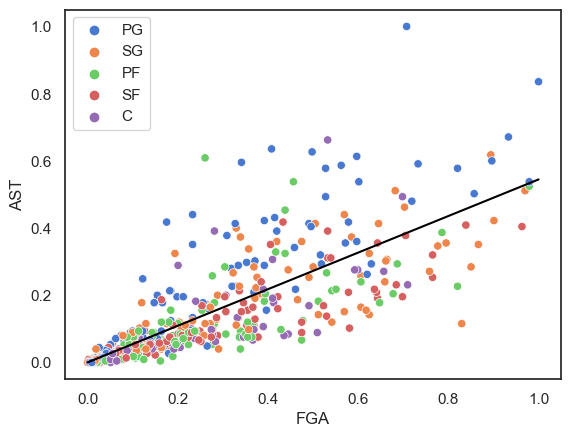

In [95]:
sns.scatterplot(df_players, x='FGA', y='AST',hue="POSITION")
sns.lineplot(x=[0,1],y=([0,1]*lr.coef_[0] + lr.intercept_[0]),c="black")

Finaly, we wanted to see the distribution of the player efficiency rating, and see who is the best current player

In [96]:
df = pd.read_csv("Data/NBA_Players_Stats.csv")
df = df[df["MIN"] != 0]

teams = pd.read_csv("Data/NBA_Teams_Stats.csv")

df = df.merge(teams[["AST", "FGM","PACE","TEAM_ID"]], on="TEAM_ID", how="left", suffixes=("", "_TEAM"))

df = df[df["MIN"] >30]

# calculate player efficiency rating


factor = 2 / 3 - (0.5 * (df["AST"].mean() / df["FGM"].mean())) / (2 * df["FGM"].mean() / df["FTM"].mean())
VOP = df["PTS"].mean() / ( df["FGA"].mean()- df["OREB"].mean() + df["TOV"].mean() + 0.44 * df["FTA"].mean() )
DRBP = df["REB"].mean() - df["OREB"].mean() / (df["REB"].mean())
uPER = 1 / (df["MIN"]) * (df["FG3M"] + (df["AST"] * 2 / 3) + ((2 - factor * df["AST_TEAM"] / df["FGM_TEAM"])
        * df["FGM"]) + (0.5 * df["FTM"] * (2-1/3 * df["AST_TEAM"] / df["FGM_TEAM"]))-VOP *(DRBP *(2*df["OREB"]+ df["BLK"]
        - 0.2464 *(df["FTA"]-df["FTM"])-(df["FGA"]-df["FGM"])- df["REB"]) + (0.44 * df["FTA"].mean()*df["PFD"])/df["PFD"].mean()
        -(df["TOV"]-df["OREB"])-df["STL"] + df["REB"]-1.936*(df["FTA"]-df["FTM"])) + df["PFD"]*df["FTM"].mean()/df["PFD"].mean())

df["PER"] = (uPER * df["PACE"].mean()/ df["PACE"])* 15/uPER.mean()
df[df["PER"]<0] = 0

We obtain the PER for each player that have played more than 30 minutes
This score is normalized around the value 15


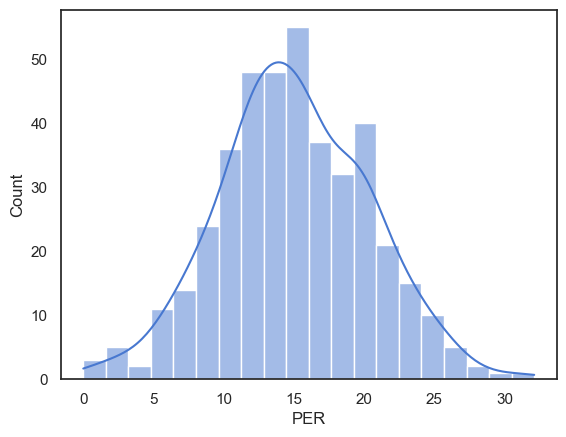

In [97]:

sns.histplot(df["PER"], bins=20, kde=True)
plt.show()


And now we can check : Who is the best current player in nba?
And now we can check : Who is the best current player in nba?

In [98]:
print(df[df["PER"] == df["PER"].max()]["PLAYER_NAME"].values)

['Giannis Antetokounmpo']
